In [1]:
pip install imbalanced-learn

     |████████████████████████████████| 167 kB 3.5 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
url="https://bd29ee0e-54ab-4daa-9671-d153865d1620.usrfiles.com/ugd/bd29ee_c8e8737b5e7944258a01aa96538bd1b2.csv"
df=pd.read_csv(url,header=None)
df.head()

,0,1,2,3,4,5,6
0,85,92,45,27,31,0.0,1
1,85,64,59,32,23,0.0,2
2,86,54,33,16,54,0.0,2
3,91,78,34,24,36,0.0,2
4,87,70,12,28,10,0.0,2


In [3]:
df.shape

(345, 7)

In [4]:
df=df.rename(columns={0:"mcv",1:"alkphos",2:"sgpt",3:"sgot",4:"gammagt",5:"alcoholic consumption",6:"Class"})
df.head()

,mcv,alkphos,sgpt,sgot,gammagt,alcoholic consumption,Class
0,85,92,45,27,31,0.0,1
1,85,64,59,32,23,0.0,2
2,86,54,33,16,54,0.0,2
3,91,78,34,24,36,0.0,2
4,87,70,12,28,10,0.0,2


In [5]:
df.isna().any()

mcv                      False
alkphos                  False
sgpt                     False
sgot                     False
gammagt                  False
alcoholic consumption    False
Class                    False
dtype: bool

In [6]:
df.groupby("Class").count().T

Class,1,2
mcv,145,200
alkphos,145,200
sgpt,145,200
sgot,145,200
gammagt,145,200
alcoholic consumption,145,200


In [7]:
X=df.drop(["Class"],axis=1)
X.head()

,mcv,alkphos,sgpt,sgot,gammagt,alcoholic consumption
0,85,92,45,27,31,0.0
1,85,64,59,32,23,0.0
2,86,54,33,16,54,0.0
3,91,78,34,24,36,0.0
4,87,70,12,28,10,0.0


In [8]:
y=df[["Class"]]
y.head()

,Class
0,1
1,2
2,2
3,2
4,2


In [9]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X=pd.DataFrame(scaler.fit_transform(X),columns=X.columns)
X.head()

,mcv,alkphos,sgpt,sgot,gammagt,alcoholic consumption
0,-1.161601,1.207923,0.749035,0.234482,-0.185829,-1.036627
1,-1.161601,-0.320373,1.467573,0.732000,-0.389922,-1.036627
2,-0.936459,-0.866193,0.133145,-0.860056,0.400941,-1.036627
3,0.189250,0.443775,0.184469,-0.064028,-0.058270,-1.036627
4,-0.711318,0.007119,-0.944662,0.333986,-0.721575,-1.036627


In [10]:
import numpy as np
from numpy import set_printoptions
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# feature extraction. We are going to output the selection scores for all features and select the features with the highest scores.
test = SelectKBest(score_func=f_classif, k="all")
fit = test.fit(X, np.asarray(y).reshape(y.shape[0],))
features = fit.transform(X)
# summarize scores
set_printoptions(precision=3)

scores=fit.scores_
scores=pd.DataFrame(scores)
scores=scores.rename(columns={0:"scores"})
scores=scores.sort_values(by=["scores"],ascending=False)
scores

,scores
3,8.708603
4,7.511737
1,3.329556
0,2.868553
2,0.420902
5,0.166826


In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape)
print(X_test.shape)

(241, 6)
(104, 6)


In [12]:
from imblearn.ensemble import BalancedRandomForestClassifier
import numpy as np
from sklearn import model_selection
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

BForest=BalancedRandomForestClassifier(n_estimators=215,criterion="entropy",max_depth=6,min_samples_split=4,min_samples_leaf=2,max_features="sqrt",bootstrap=True,sampling_strategy="not majority",replacement=True,n_jobs=-1,warm_start=False,class_weight="balanced",random_state=0).fit(X_train,y_train)
BForest

/srv/conda/envs/notebook/lib/python3.6/site-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


BalancedRandomForestClassifier(class_weight='balanced', criterion='entropy',
                               max_depth=6, max_features='sqrt',
                               min_samples_leaf=2, min_samples_split=4,
                               n_estimators=215, n_jobs=-1, random_state=0,
                               replacement=True,
                               sampling_strategy='not majority')

In [14]:
from sklearn.metrics import accuracy_score as accuracy
ytrain_pred=BForest.predict(X_train)
ytest_pred=BForest.predict(X_test)
print("Accuracy on train data: ",accuracy(y_train,ytrain_pred))
print("Accuracy on test data: ",accuracy(y_test,ytest_pred))

Accuracy on train data:  0.8921161825726142
Accuracy on test data:  0.7692307692307693


In [15]:
from sklearn.metrics import roc_auc_score as auc
print("AUC on train data: ",auc(y_train,ytrain_pred))
print("AUC on test data: ",auc(y_test,ytest_pred))

AUC on train data:  0.8740452616690241
AUC on test data:  0.7424242424242423


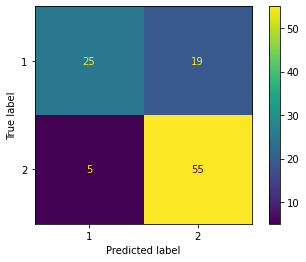

In [17]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
plot_confusion_matrix(BForest,X_test,y_test)
plt.show()

In [18]:
print("Sensitivity: ",25/(25+19))
print("Specificity: ",55/(55+5))

Sensitivity:  0.5681818181818182
Specificity:  0.9166666666666666


In [19]:
from sklearn.ensemble import RandomForestClassifier
forest=RandomForestClassifier(n_estimators=140,criterion="entropy",max_depth=8,min_samples_split=4,min_samples_leaf=3,max_features="sqrt",bootstrap=True,n_jobs=-1,warm_start=True,class_weight="balanced_subsample",ccp_alpha=0.01,random_state=0).fit(X_train,y_train)
forest

/srv/conda/envs/notebook/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/srv/conda/envs/notebook/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '


RandomForestClassifier(ccp_alpha=0.01, class_weight='balanced_subsample',
                       criterion='entropy', max_depth=8, max_features='sqrt',
                       min_samples_leaf=3, min_samples_split=4,
                       n_estimators=140, n_jobs=-1, random_state=0,
                       warm_start=True)

In [20]:
ytrain_pred=forest.predict(X_train)
ytest_pred=forest.predict(X_test)
print("Accuracy on train data: ",accuracy(y_train,ytrain_pred))
print("Accuracy on test data: ",accuracy(y_test,ytest_pred))

Accuracy on train data:  0.9377593360995851
Accuracy on test data:  0.7884615384615384


In [21]:
from sklearn.metrics import roc_auc_score as auc
print("AUC on train data: ",auc(y_train,ytrain_pred))
print("AUC on test data: ",auc(y_test,ytest_pred))

AUC on train data:  0.9326379066478078
AUC on test data:  0.7742424242424244


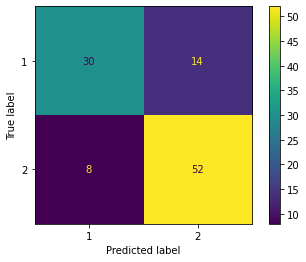

In [22]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(forest,X_test,y_test)
plt.show()

In [23]:
print("Sensitivity: ",30/(30+14))
print("Specificity: ",52/(52+8))

Sensitivity:  0.6818181818181818
Specificity:  0.8666666666666667


In [24]:
y_pred=pd.DataFrame(forest.predict_proba(X_test)).rename(columns={0:"pred_0",1:"pred_1"})
y_pred.head()

,pred_0,pred_1
0,0.630969,0.369031
1,0.399908,0.600092
2,0.279200,0.720800
3,0.829825,0.170175
4,0.188229,0.811771


In [25]:
y_probs1=y_pred[["pred_1"]]

In [26]:
import numpy as np
thresholds=np.arange(0,1,0.001)

In [27]:
def to_labels(pos_probs,threshold):
    return (pos_probs >= threshold).astype('int')

In [28]:
from sklearn.metrics import f1_score
scores=[f1_score(y_test, to_labels(y_probs1,t),average="micro") for t in thresholds]

In [29]:
ix=np.argmax(scores)
print((thresholds[ix],scores[ix]))

(0.0, 0.4230769230769231)


No room for improvements.

In [30]:
from sklearn import svm
import numpy as np

svm=svm.SVC(C=0.4,kernel="linear",degree=3,gamma="auto",cache_size=10,
            decision_function_shape="ovo",probability=True,random_state=0).fit(X_train,y_train)
svm

/srv/conda/envs/notebook/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


SVC(C=0.4, cache_size=10, decision_function_shape='ovo', gamma='auto',
    kernel='linear', probability=True, random_state=0)

In [31]:
ytrain_pred=svm.predict(X_train)
ytest_pred=svm.predict(X_test)
print("Accuracy on train data: ",accuracy(y_train,ytrain_pred))
print("Accuracy on test data: ",accuracy(y_test,ytest_pred))

Accuracy on train data:  0.6970954356846473
Accuracy on test data:  0.7307692307692307


### RandomForestClassifier delivered the best result.